## Image Stitching

* https://paper.dropbox.com/doc/Image-Stitching-dezr13pcXOLh5EVftRP5s

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/bfortuner/workplace/VisionQuest")
from common import *

## Dataset

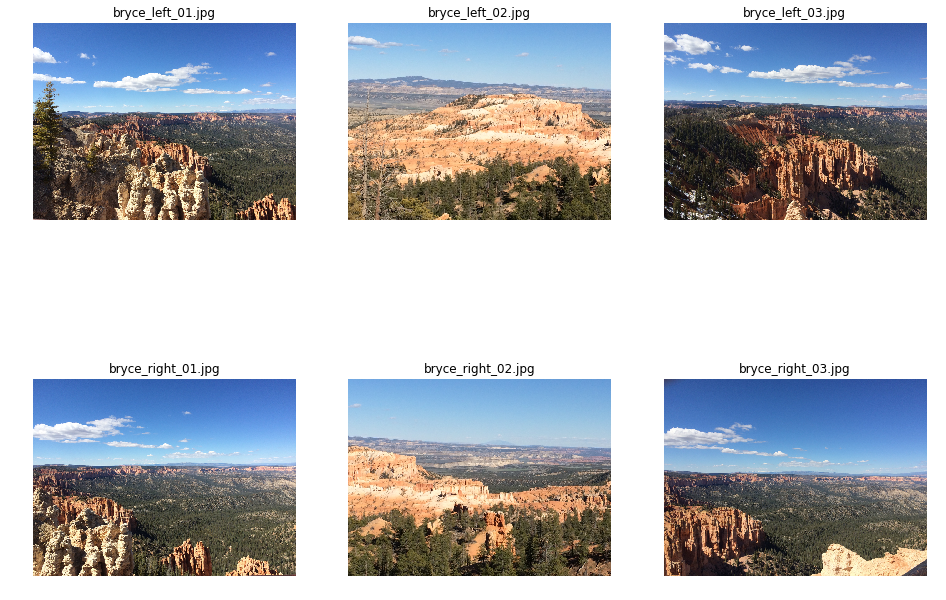

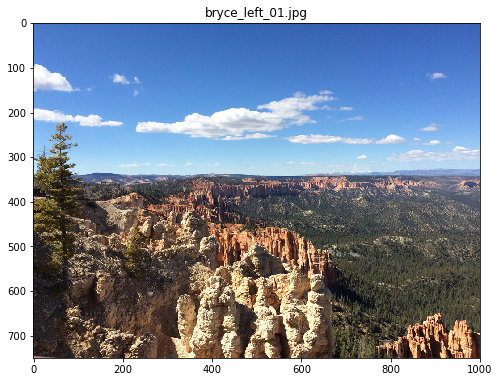

In [2]:
IMG_DIR = '../data/panorama/'
img_fpaths, img_fnames = utils.files.get_paths_to_files(IMG_DIR, file_ext='.jpg')
img_fpaths, img_fnames
utils.imgs.plot_samples_from_dir(IMG_DIR)
utils.imgs.plot_img_from_fpath(img_fpaths[0], title=img_fnames[0])

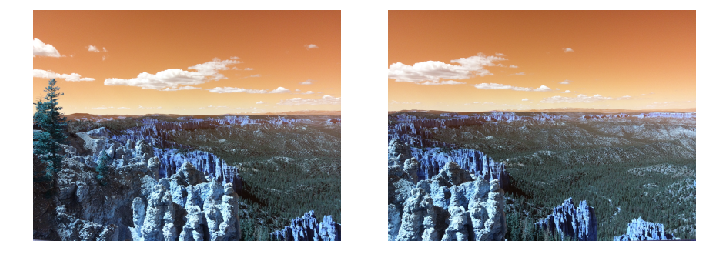

In [110]:
def load_img_pair(fname_left, fname_right):    
    imgA_fpath = os.path.join(IMG_DIR, imgA_fname)
    imgB_fpath = os.path.join(IMG_DIR, imgB_fname)

    # Read and resize images, figures out the height automatically
    imgA = cv2.imread(imgA_fpath) # does some normalization?
    imgB = cv2.imread(imgB_fpath)

    imgA = imutils.resize(imgA, width=400)
    imgB = imutils.resize(imgB, width=400)

    return imgA, imgB

# Initialize Test Images (Left and Right)
left_fname = 'bryce_left_01.jpg'
right_fname = 'bryce_right_01.jpg'
imgA_arr, imgB_arr = load_img_pair(left_fname, right_fname)
img_batch = np.stack([imgA_arr, imgB_arr], axis=0)

# utils.imgs.plot_img_arr(imgA_arr, title='A (left)')
# utils.imgs.plot_img_arr(imgB_arr, title='B (right)')
utils.imgs.plot_rgb_samples(img_batch, dim=(1,2), figsize=(10,10))

## Extract Keypoints with SIFT

* SIFT "features"
* Keypoints 
* DoG

In [111]:
def extract_keypoints_descriptors(img):
    """Extracts keypoints and local invariant descriptors w SIFT

    Args:
        img (np.array): The image array

    Returns:
        kps (np.array): array of keypoints
        features (np.array): array of feature vectors which quantify the 
            region surrounding each detected keypoint
    """    
    # Extract features with SIFT
    descriptor = cv2.xfeatures2d.SIFT_create()
    kps, features = descriptor.detectAndCompute(img, None)
    
    # Convert KeyPoint objects to Numpy
    kps = np.float32([kp.pt for kp in kps])
    
    return kps, features

## Match Keypoints with KNN, Homography, RANSAC

* KNN - https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
* Homography
* RANSAC
* Euclidian Distance
* Lowe's Ratio Test

In [106]:
def match_keypoints(kpsA, kpsB, featA, featB, ratio, reproj_thresh):
    """
    Args:
        kpsA (np.array): The first image
        kpsB (np.array): The second image
        featA (np.array): feature vectors describing area around keypoints
        featB (np.array): feature vectors describing area around keypoints
        ratio (float): 
        reproj_thresh (float): maximum pixel wiggle room for RANSAC

    Returns:
        matches ():
        H (): homography matrix derived from RANSAC
        status (list): indicies to indicate which keypoints in 
            matches were spacially verified w RANSAC
    """
    
    # Loop over features in imgA, compute (Euclidian) distance to every other 
    # feature in imgB, find smallest distance for each pair of features
    # BruteForce - exhaustively compare ALL feature vectors
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    
    # Compare 2 feature vector sets with K-nearest neighbor matching
    raw_matches = matcher.knnMatch(featA, featB, 2)
    matches = []
    
    # Filter out False Positives with Lowe's Ratio Test
    # Confirm distance between imgs in pair is within ratio
    for m in raw_matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            
    # Compute Homography between 2 sets of keypoints
    # Requires >= 4 matches (more the better)
    if len(matches) > 4:
        ptsA = np.float32([kpsA[i] for (_,i) in matches])
        ptsB = np.float32([kpsB[i] for (i,_) in matches])
        
        # Compute Homography matrix with RANSAC
        H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reproj_thresh)
        
        return matches, H, status
    
    return None

## Warp Perspective

* oins

In [107]:
def warp_perspective():
    pass

## Stitch Images

In [114]:
def draw_matches(imgA, imgB, kpsA, kpsB, matches, status):
    """
    """
    hA, wA = imgA.shape[:2]
    hB, wB = imgB.shape[:2]
    
    viz = np.zeros((max(hA,hB), wA+wB, 3), dtype='uint8')
    viz[0:hA, 0:wA] = imgA
    viz[0:hB, wA:] = imgB
    
    for ((trn_idx, query_idx), s) in zip(matches, status):
        if s == 1:
            ptA = int(kpsA[query_idx][0]), int(kpsA[query_idx][1])
            ptB = int(kpsB[trn_idx][0]) + wA, int(kpsB[trn_idx][1])
            cv2.line(viz, ptA, ptB, (0,255,0), 1)
    return viz

def stitch_images(imgLeft, imgRight, ratio=.75, reproj_thresh=4.0):
    """Stitches together two images into a combined panorama
    
    Args:
        imgLeft (np.array): The left image
        imgRight (np.array): The right image
        ratio (float): ratio test when matching features
        reproj_thresh (float): maximum pixel wiggle room for RANSAC

    Returns:
        np.array: The stiched image. Otherwise None if no match found.
    """
    
    # Swap the images
    # Methods below assume the right-most image is 1st
    imgA, imgB = imgRight, imgLeft
    
    # Detect Keypoints
    # Extract local invariant descriptors
    kpsA, featA = extract_keypoints_descriptors(imgA)
    kpsB, featB = extract_keypoints_descriptors(imgB)
#    print("Keypoints", kpsA, kpsB)
#    print("Features", featA, featB)
    
    # Match features
    match = match_keypoints(kpsA, kpsB, featA, featB, 
                            ratio, reproj_thresh)
    
    if match is None:
        print("No match found")
        return None
    matches, H, status = match
    
    # Perspective warp to stitch images
    img_stitch = cv2.warpPerspective(
        imgA, H, (imgA.shape[1] + imgB.shape[1], imgA.shape[0]))
#    utils.imgs.plot_img_arr(img_stitch)
    img_stitch[0:imgB.shape[0], 0:imgB.shape[1]] = imgB
#     utils.imgs.plot_img_arr(imgA)
#     utils.imgs.plot_img_arr(imgB)
#     utils.imgs.plot_img_arr(img_stitch)
    
    # Visualization
    #print(kpsA.shape, kpsB.shape, matches, status.shape)
    viz = draw_matches(imgA, imgB, kpsA, kpsB, matches, status)
    
    return img_stitch, viz

## Test

(300, 800, 3)


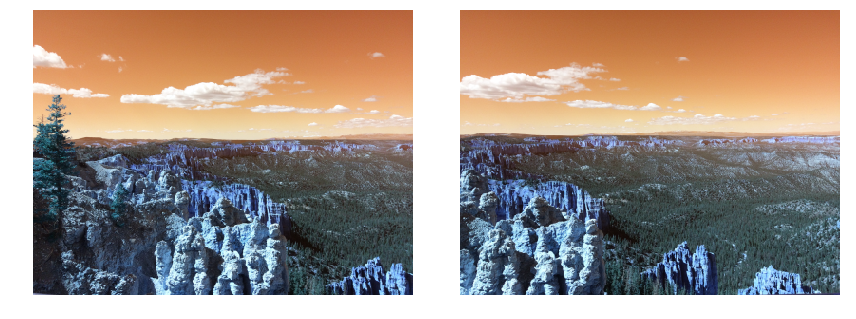

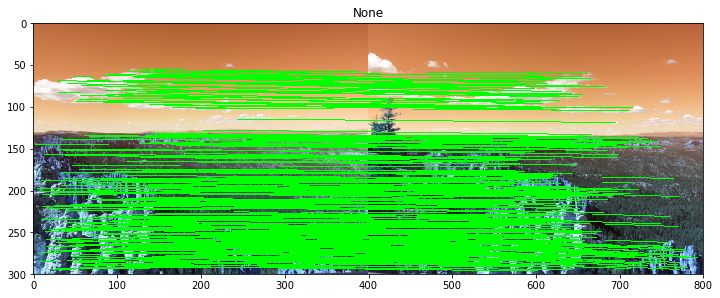

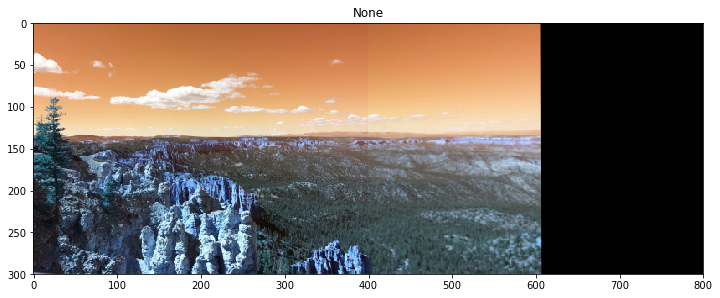

In [117]:
img_stitch, keypoint_viz = stitch_images(imgA_arr, imgB_arr)
utils.imgs.plot_rgb_samples(img_batch, dim=(1,2), figsize=(12,12))
print(img_stitch.shape)
utils.imgs.plot_img_arr(keypoint_viz, fs=(12,12))
utils.imgs.plot_img_arr(img_stitch, fs=(12,12))

## Sources

* rename -n 's/\.png/\.jpg/' *.png 
* https://en.wikipedia.org/wiki/Image_stitching
* https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/
* http://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html
* https://stackoverflow.com/questions/24563173/stitch-multiple-images-using-opencv-python